## 🔍 Decoder-Only Transformer Attention Masking (Autoregressive)

In a decoder-only transformer (like GPT), the model must generate one token at a time and should not look ahead. This is enforced through a technique called causal masking.

### 🧠 Attention Score Matrix (Before Softmax)

The attention scores define how much each token should "attend" to every other token. But because we're generating sequentially, each token is only allowed to look at previous tokens (including itself), and not future tokens. This restriction is applied using a triangular mask filled with -inf in invalid positions.

### ✅ Allowed Attention / ❌ Masked Attention

The following matrix shows a 4-token input: "You are good too"  
Each row shows the token doing the attending; each column shows the token being attended to.

|         | You | Are | Good | Too |
|---------|-----|-----|------|-----|
| You | ✅  | ❌  | ❌   | ❌  |
| Are | ✅  | ✅  | ❌   | ❌  |
| **Good**| ✅  | ✅  | ✅   | ❌  |
| Too | ✅  | ✅  | ✅   | ✅  |

### 🧮 What happens internally?

For each token:

- The model computes Q, K, V matrices (queries, keys, values).
- Attention scores are computed as Q @ K^T / sqrt(d_k).
- The causal mask (as above) is applied: masked entries are set to -inf.
- The scores are passed through softmax.
- The result is multiplied by V to produce the context vector.

### 📤 Final Output Projection

Once all transformer layers are applied:
- The final hidden state has shape: (batch, seq_len, emb_dim)
- A final linear layer projects this into shape: (batch, seq_len, vocab_size)
- This is used to compute the logits for next-token prediction.
- softmax is then applied, and the token with the highest probability is selected.

### 🤖 During Inference

Even during inference, the model runs full attention over all previous tokens, applying the same masking as above. It starts with a prompt like:
You → mask mask mask mask
You are → mask mask mask
You are good → mask mask

...until it finally generates:
You are good too <eos>

### Summary:
- Decoder-only transformers use masked attention.
- Each token sees only itself and tokens before it.
- Final layer maps embedding to vocabulary space.
- Predictions are made by selecting the token with the highest logit.

# Chapter 4 – Implementing a GPT model from scratch to generate text

In this chapter, we will implement all the necessary building blocks to construct a real GPT model from scratch — a model capable of generating human-like text sequences.

---

## 🧠 What you will learn in this chapter:

1. Building a large language model (LLM) that can generate coherent, human-like text.
2. Normalizing activations (e.g., LayerNorm) to stabilize neural network training.
3. Adding shortcut connections (Residuals) to enable effective deep learning.
4. Implementing complete Transformer blocks, including:
   - Embedding
   - Positional Encoding
   - Multi-head Attention
   - Projection layer
5. Computing parameter counts and memory requirements of GPT-style models.

---

## ✅ Outcome of this chapter:

By the end of this chapter, you will be able to:

- Build a GPT-like model entirely from scratch.
- Assemble all components of an LLM.
- Be fully prepared to train the model to generate text in the next chapter.

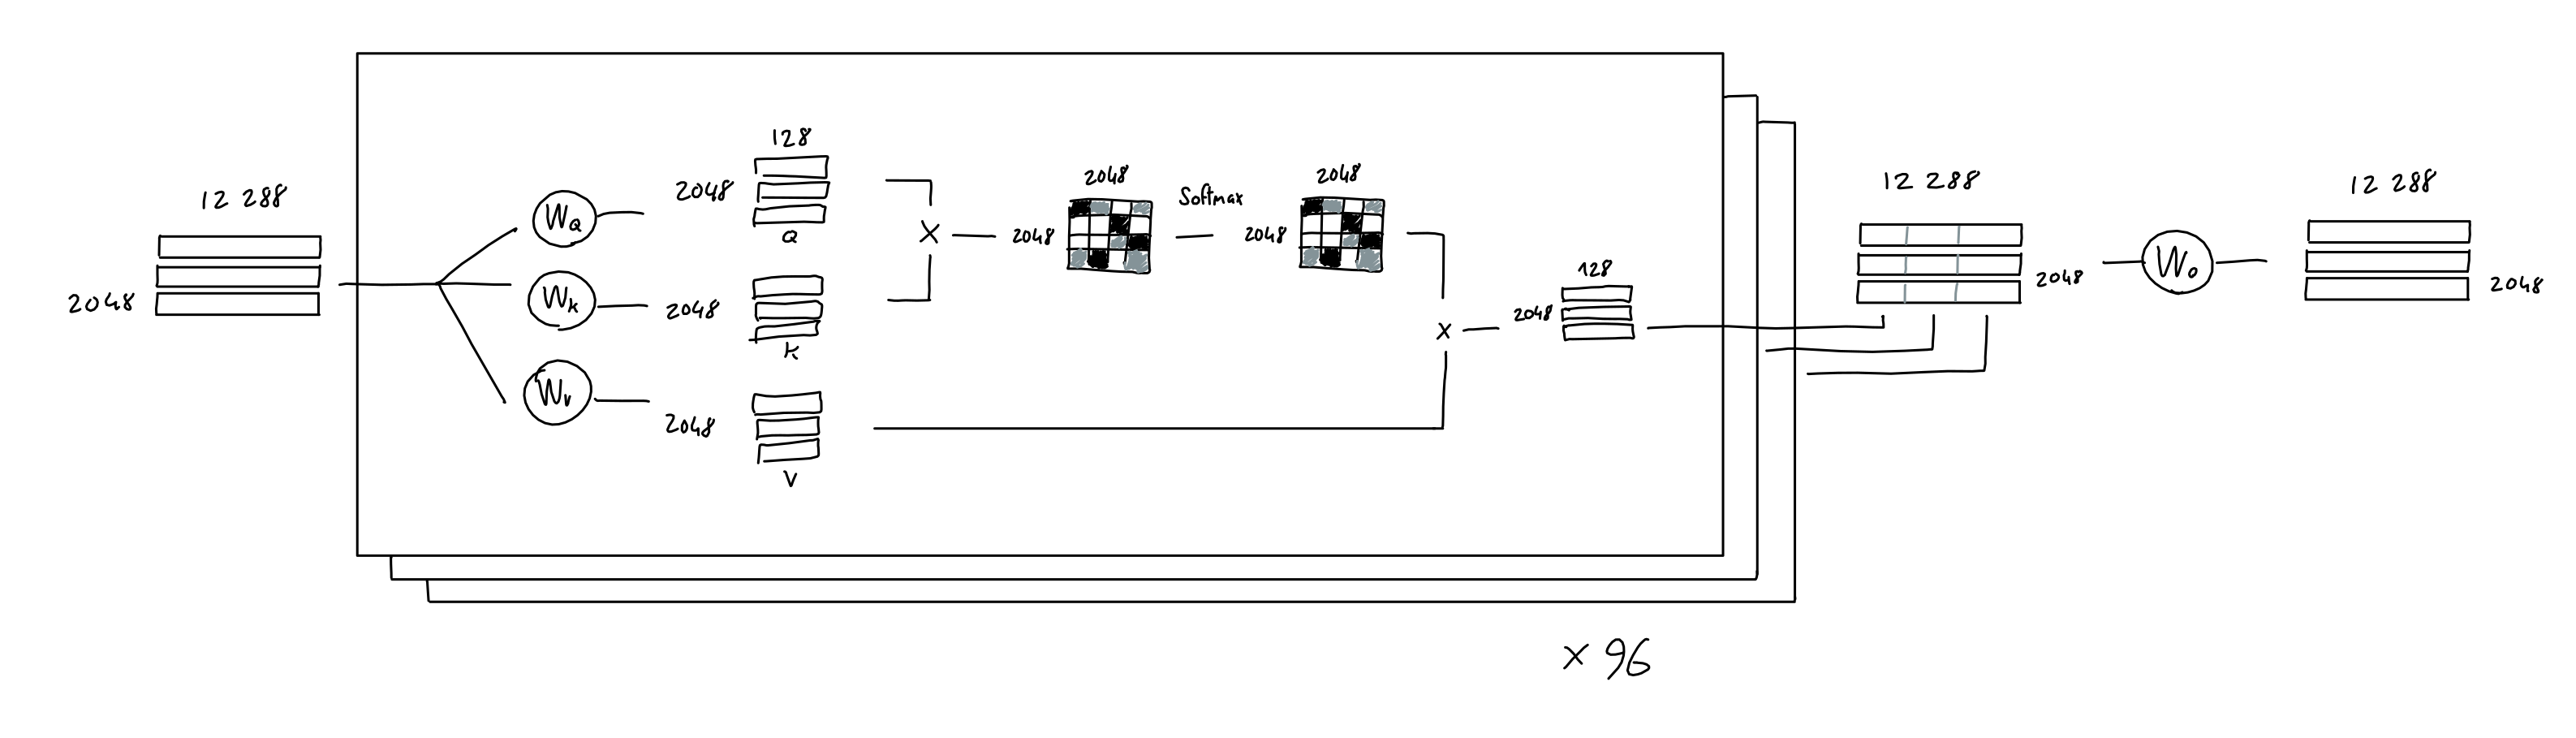

In [1]:
# __numpy is a fundamental package for scientific computing with Python__
import numpy as np

# __torch is a special module that allows us to use PyTorch's tensor operations__
import torch

# __torch.nn is a module that contains various neural network modules
import torch.nn as nn

print("Numpy version:", np.__version__)
print("Torch version:", torch.__version__)

Numpy version: 1.26.4
Torch version: 2.6.0+cu124


### 📝 Minimal GPT-Style cfg (Essential Keys Only)

| Key | Purpose (English) |
|-----|-------------------|
| vocab_size | Size of the tokenizer vocabulary. |
| emb_dim | Model/embedding dimension  (d_model). |
| num_layers | Number of Transformer blocks. |
| num_heads | Attention heads per block. |
| ff_dim | Hidden dimension of the feed-forward sub-layer. |
| max_seq_len | Maximum input sequence length. |
| dropout | Dropout rate inside each block. |
| activation_function | Non-linearity in FFN (e.g. `gelu`). |
| layer_norm_epsilon | Epsilon for all LayerNorms. |
| initializer_range | Weight init std-dev (e.g. 0.02). |
| tie_word_embeddings | Share input & output embeddings (`True` for GPT). |
| use_cache | Enable KV-cache for fast autoregressive inference. |
| use_attention_mask | Apply causal mask to prevent information leak. |
| pad_token_id | Padding token ID (if padding is used). |
| bos_token_id | Beginning-of-sentence token ID. |
| eos_token_id | End-of-sentence token ID. |

# 🔁 Decoder-Only Transformer (GPT-style) - Step-by-Step Breakdown

This document describes the full process of a decoder-only transformer predicting the next token based on previous tokens. Let's assume the sequence is:

**"You are good too"**

We want to predict **"too"** given the prefix **"You are good"**.

---

## 🧱 1. Tokenization

Convert the input sentence to token IDs using a tokenizer (e.g., `tiktoken`):
```
"You are good" → [103, 204, 305]  # (token_ids)
```

---

## 📐 2. Embedding Layer

Each token ID is mapped to a vector using a learned embedding table:
```
Input shape: (num_tokens = 3,)
→ Embedding shape: (3, emb_dim = 512)
```

---

## 📍 3. Positional Encoding

Add learned **positional embeddings** to each token embedding:
```
Token Embeddings:     (3, 512)
+ Positional Embeddings: (3, 512)
= Final Input:        (3, 512)
```

---

## 🧠 4. Linear Projections to Q, K, V

Project the input to **Query (Q)**, **Key (K)**, and **Value (V)** vectors using `nn.Linear`:
```
Input: (3, 512)
Q, K, V → shape: (3, num_heads, head_dim) → (3, 8, 64)
```

---

## 🎯 5. Attention Score Calculation

For each token, compute the dot product between Q and Kᵗ across time:
```
Q @ Kᵗ → (3, 3) matrix per head
This gives us the "attention scores".
```

---

## ⛔ 6. Apply Causal Mask (autoregressive)

Use a lower-triangular mask to prevent tokens from attending to future positions:
```text
You   ✓ ✗ ✗
Are   ✓ ✓ ✗
Good  ✓ ✓ ✓
```
Masked positions are replaced with `-inf` before softmax.

---

## 🧮 7. Softmax Over Attention Scores

Normalize attention scores across the sequence length (dim = -1):
```
attn_weights = softmax(masked_scores)
```

---

## 📦 8. Weighted Sum of Values

Use attention weights to compute the final attention output:
```
attn_output = attn_weights @ V
```
Resulting shape: `(3, num_heads, head_dim)`

---

## 🔗 9. Concatenation + Linear Projection

Concatenate all heads and pass through a final linear projection layer:
```
attn_output shape: (3, 512)
```

This restores the same shape as the original input embedding dimension.

---

## 🏗 10. Feedforward Network + LayerNorm

Pass through a 2-layer MLP (position-wise feedforward) and residual connection:
```python
x = x + attn_output
x = x + MLP(LayerNorm(x))
```

---

## 🔚 11. Final Output Projection (to Vocabulary)

Project each token’s final representation (dim=512) to vocabulary logits:
```python
logits = nn.Linear(512, vocab_size=10000)(x)
```
This gives:
```
logits: (3, 10000)
```

Each row is a vector of logits over the entire vocabulary — one per token.

---

## 🎯 12. Next Token Prediction

Apply `softmax` over logits of the **last token** to get a probability distribution:
```
predicted_token_id = argmax(softmax(logits[-1]))
```

Example:
```text
"You are good" → predicts "too"
```

---

> ✅ This is the core pipeline of autoregressive generation in GPT-style LLMs. The model sees the **entire previous context**, attends only to the past, and predicts the next token one-by-one.


## Why We Use Classes (e.g., Q, K, V, Embeddings) in NLP Models Like GPT

Defining layers like Q, K, V, and embeddings inside the __init__ method of a nn.Module class is a best practice in PyTorch. Here’s why:

| Reason | Explanation |
|--------|-------------|
| 1) One-time creation, multiple use | Learnable weights are initialized once and reused throughout training and inference. If you create them inside forward, new weights are generated each time, preventing learning. |
| 2) Automatic registration in PyTorch | When defined in __init__, PyTorch automatically registers them in model.parameters() and state_dict. This makes model saving/loading, .to(device) transfers, and .eval() seamless. |
| 3) Maintains state cleanly | The class (`nn.Module`) acts as a stateful container. All learnable components, configs, and operations are bundled together, making the model easier to manage and reason about. |
| 4) Easier debugging and development | With named and structured components, you can easily inspect the model (`print(model)`), test individual layers, or replace parts during experimentation. |
| 5) Enables weight sharing | Defining layers as modules makes techniques like weight tying trivial. For example: self.out.weight = self.tok_emb.weight allows shared weights between input and output embeddings. |

### Conclusion

> Defining components in __init__ ensures reusability, state consistency, and makes the model manageable, debuggable, and PyTorch-compliant.

In [2]:
from types import SimpleNamespace

GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

# ___Initialize the GPT model with the given configuration___
# ___cfg should contain keys like 'vocab_size', 'emb_dim', etc.___
#__This is a placeholder for the actual GPT model implementation___
# ___In a real implementation, you would replace DummyGPTModel with the actual GPT model class


## 📌 Weight Matrix in `nn.Embedding(vocab_size, emb_dim)`

When you define:

```python
nn.Embedding(vocab_size, emb_dim)

You’re creating a learnable weight matrix shaped as:

          Feature 1   Feature 2   ...   Feature emb_dim
Token 0     w01         w02        ...      w0e
Token 1     w11         w12        ...      w1e
...         ...         ...        ...      ...
Token V     wv1         wv2        ...      wve


⸻

✅ Example

nn.Embedding(1000, 64)

 • vocab_size = 1000 → 1000 rows (one for each token)
 • emb_dim = 64 → each token maps to a 64-dimensional vector

⸻

✅ What happens at inference?

If the model receives token index = 27,
it simply returns row 27 of the matrix,
which is a vector of size 64.

⸻

✅ Summary
 • Embedding layer is like a lookup table.
 • Input: token index (e.g. 27)
 • Output: dense vector from the matrix (row 27)
 • Shape of embedding matrix: (vocab_size, emb_dim)

---

In [3]:
"""why using conctruction?
    1. It allows for a more modular and flexible design, where different components can be easily swapped or modified.
    2. It promotes code reuse, as common components can be defined once and used in multiple places
    3. It can lead to cleaner and more maintainable code, as each component can be tested and debugged independently.
    4. It can improve performance by allowing for more efficient memory usage and computation, as components can be optimized separately.
    5. save state and load model, which is essential for training and inference in deep learning models.
    6. create every classes or functions just once, and then use them multiple times without redefining them.
    Also, if use it in forward, it will create new instances every time the forward method is called,
    which can lead to memory leaks and performance issues.
    7.All in all, every learnable model should be constructed using a class, 
    which is a fundamental principle in object-oriented programming.
    """

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        # ___Initialize the GPT model with the given configuration.___
        # ___cfg should contain keys like 'vocab_size', 'emb_dim', etc.___
        # ___This is a placeholder for the actual GPT model implementation with accidental values___
        super().__init__()
        self.cfg = cfg
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.emb_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(cfg.context_length, cfg.emb_dim)
        self.drop_emb = nn.Dropout(cfg.drop_rate)

        # ___Assuming cfg has a 'num_layers' key for the number of transformer blocks___
        # ___trf_blocks shown in the original code is a typo, it should be nn.Sequential___
        # ___trf_blocks contains multiple transformer blocks including self-attention |>**            
        # **|> and feed-forward layers, layer normalization and dropout___
        # ___This is a placeholder for the actual transformer blocks___
        # ___In a real implementation, you would replace DummyTransformerBlock with actual transformer block classes
        # ___that implement self-attention, feed-forward networks, and layer normalization___
        self.trf_blocks = nn.Sequential(         
          *[DummyTransformerBlock(cfg) for _ in range(cfg.n_layers)]
        )

        # ___Final layer normalization to stabilize the output of the transformer blocks___
        self.final_norm = DummyLayerNorm(cfg.emb_dim)

        # ___Output head to project the final hidden states to vocabulary size___
        # ___This is typically a linear layer that maps the hidden states to logits for each token
        # ___in the vocabulary, which can then be used for next-token prediction___
        #___In a real implementation, this would be a linear layer with bias set to False___
        self.out_head = nn.Linear(cfg.emb_dim,  cfg.vocab_size, bias=False)

    def forward(self, in_idx):
        # ___Forward pass through the model___
        # ___in_idx is expected to be a tensor of token indices with shape (batch_size, seq_len)___
        # ___This is a placeholder for the actual forward pass implementation___

        # ___Extract batch size and sequence length from the input indices___
        # ___This is necessary to understand the shape of the input tensor for further processing___
        # ___seq_len is the length of the input sequence, and batch_size is the number of sequences in a batch___
        # ___in_idx.shape returns a tuple (batch_size, seq_len)___
        batch_size, seq_len = in_idx.shape

        # ___Get token embeddings for the input indices___
        # ___This converts token indices into dense vector representations (embeddings)___
        tok_embeds = self.tok_emb(in_idx)

        # ___Get positional embeddings for the sequence length___
        # ___This adds positional information to the token embeddings, allowing the model to understand the order
        # ___torch.arange(seq_len, device=in_idx.device) creates a tensor of positions from 0 to seq_len-1___
        # ___and expands it to match the batch size___
        # ___unsqueeze(0) adds a new dimension at the start, and expand(batch_size, -1, -1) replicates it for each batch___            # using un
        # ___ device=in_idx.device ensures that the positional embeddings are on the same device as the input indices___
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
            
        # ___Combine token and positional embeddings___
        # ___This is done by adding the two embeddings together, which allows the model to leverage
        x = tok_embeds + pos_embeds
        
        # ___both the content of the tokens and their positions in the sequence___
        # ___The dropout layer is applied to prevent overfitting during training___
        x = self.drop_emb(x)
        
        # ___Pass the combined embeddings through the transformer blocks___
        # ___This is where the self-attention and feed-forward layers process the input sequence___ 
        x = self.trf_blocks(x)
        
        # ___Apply final layer normalization to stabilize the output___
        x = self.final_norm(x)
        
        # ___Project the final hidden states to the vocabulary size for next-token prediction___
        logits = self.out_head(x)
        
        # ___Return the output logits, which can be used for next-token prediction or other tasks
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        # ___Placeholder for the actual transformer block implementation___
        # ___In a real implementation, this would include self-attention, feed-forward networks, and layer normalization___
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
   
    def forward(self, x):
        return x


In [4]:
import tiktoken # __tiktoken is a library for tokenizing text using the GPT-2 tokenizer__

# ___Initialize the tokenizer for encoding text into token indices___
# ___This is typically done using a pre-trained tokenizer that matches the model's vocabulary___
# ___In this case, we are using the GPT-2 tokenizer from the tiktoken library___
# ___tiktoken.get_encoding("gpt2") retrieves the encoding for the GPT-2 model___
# ___This encoding will be used to convert text into token indices that the model can process___
tokenizer = tiktoken.get_encoding("gpt2")

# ___Create a batch of tokenized text inputs___
# ___This is a simple example where we create a batch with two text inputs___
# ___Each text input is tokenized using the tokenizer, which converts the text |>**
# **|> into a sequence of token indices___
batch = []
text1 = "Every effort moves you"
text2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))

# ___Convert the batch of tokenized text inputs into a PyTorch tensor___
# ___This is necessary to feed the token indices into the model for processing___
batch = torch.stack(batch, dim=0)  # ___Add a batch dimension___
print("Batch shape:", batch)
print("Batch shape:", batch.shape)

Batch shape: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Batch shape: torch.Size([2, 4])


In [5]:
# Set the random seed for reproducibility
# ___Setting a random seed ensures that the model's initialization and any random operations are consistent across
# ___runs, which is important for debugging and comparing results___
#___torch.manual_seed(123) sets the random seed for PyTorch's random number generator___
torch.manual_seed(123)

# ___Initialize the GPT model with the given configuration___
# ___cfg should contain keys like 'vocab_size', 'emb_dim', etc.___
#__This is a placeholder for the actual GPT model implementation___
# ___In a real implementation, you would replace DummyGPTModel with the actual GPT model class
cfg = SimpleNamespace(**GPT_CONFIG_124M)

# ___Create an instance of the DummyGPTModel with the specified configuration___
# ___This initializes the model with the specified vocabulary size, embedding dimension, number of layers,
model = DummyGPTModel(cfg)

# ___number of attention heads, and other hyperparameters___
# ___In a real implementation, this would be the actual GPT model class that implements the *|>
#*|> ___GPT architecture with self-attention, feed-forward networks, and layer normalization___

# Set the model to evaluation mode
# model.eval() uses the model in inference mode, which is important for models that have different behavior during training and evaluation, such as dropout layers.
# ___This is important for models that have different behavior during training and evaluation, such as dropout layers___
# model.eval()

# ___This is important for models that have different behavior during training and evaluation, such as dropout layers___
# with torch.no_grad():  # Disable gradient computation for inference
# ___This is used to save memory and computation during inference, as gradients are not needed for backpropagation___
logits = model(batch)

print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 🧠 Understanding Layer Normalization in Deep Learning

Training deep neural networks with many layers often becomes challenging due to issues like:

- Vanishing gradients: gradients become too small to update weights effectively
- Exploding gradients: gradients grow uncontrollably, destabilizing training

These problems lead to unstable training dynamics, making it difficult for the model to learn meaningful patterns in the data.

---

### 🔍 What is Layer Normalization?

Layer Normalization is a technique used to stabilize and speed up training in deep neural networks, especially transformers.

It works by:

- Adjusting the activations (outputs of a layer)
- So they have:
  - Mean = 0
  - Variance = 1 (unit variance)

This helps the network:

- Converge to good solutions faster
- Maintain stable gradients across layers
- Improve training reliability

---

### 📌 Why LayerNorm is Important in Transformers?

In modern transformer-based models like GPT-2 and GPT-3:

- LayerNorm is applied before and/or after attention and feed-forward layers
- It ensures consistent scaling of inputs
- Helps avoid instability as layers get deeper

---

### 🧩 Summary

LayerNorm = Standardization per layer (not per batch)  
✅ Helps with:  
- Gradient flow  
- Faster convergence  
- Stability across long sequences  
- Works even with batch size = 1

---

> 🔧 In our GPT model, DummyLayerNorm is used as a placeholder. In a real implementation, it would be replaced with nn.LayerNorm.

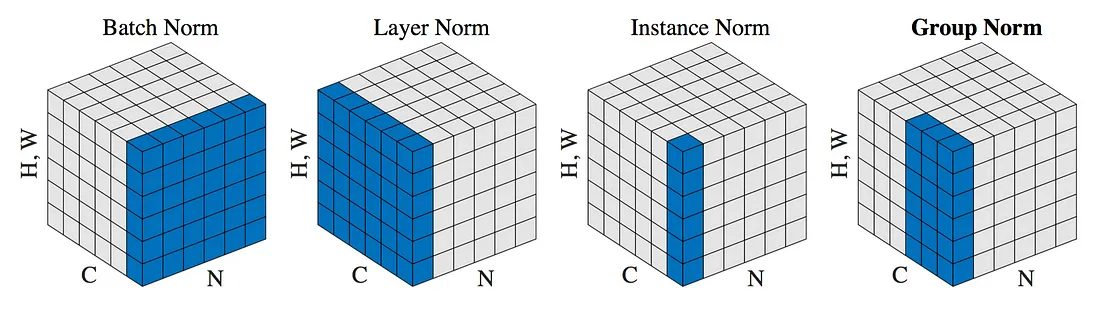

### 🔄 Layer Normalization vs. Batch Normalization

Layer Normalization (LayerNorm) and Batch Normalization (BatchNorm) are both techniques to stabilize and accelerate neural network training by normalizing activations, but they operate differently:

| Feature                    | Batch Normalization (BN)                    | Layer Normalization (LN)                     |
|---------------------------|--------------------------------------------------|--------------------------------------------------|
| Normalization axis     | Across the batch dimension                 | Across the features of a single sample       |
| Works best when        | Large batch sizes                              | Small batch sizes or batch size = 1              |
| Commonly used in       | CNNs, traditional MLPs                         | Transformers, RNNs, NLP models                   |
| Training vs Inference  | Different behavior (uses running mean/var)     | Same behavior during training and inference      |
| Batch dependence       | ✅ Yes                                           | ❌ No                                             |

---

#### 🔍 Example:

Suppose the input tensor shape is (batch_size, seq_len, emb_dim):

- BatchNorm normalizes across the batch for each feature dimension (i.e., `emb_dim`) — statistics are shared across the batch.
- LayerNorm normalizes across the feature dimensions for each sample individually.

---

#### 🧠 Why LayerNorm in Transformers?

- Transformers often operate on variable-length sequences.
- They may process one token at a time during generation.
- LayerNorm works independently of batch size, making it ideal for autoregressive models like GPT.

✅ LayerNorm is the standard in modern transformer architectures.

In [6]:
torch.manual_seed(123)  # Reset the random seed for reproducibility

# ___This ensures that the model's initialization and any random operations are consistent across runs, which
# ___is important for debugging and comparing results___
batch_example = torch.randn(2,5)  # Example tensor for demonstration


layer = nn.Sequential(
    nn.Linear(5, 6),
    nn.ReLU()
)

# ___This is a simple example of a sequential model with a linear layer followed by a ReLU activation function___
# ___In a real implementation, this would be replaced with the actual model architecture___
out = layer(batch_example)
print("Output of the sequential model:", out)
print("Batch Example:", batch_example)

Output of the sequential model: tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Batch Example: tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


In [7]:
# ___Calculate the mean and variance of the output tensor along the specified dimension___
# ___This is useful for understanding the distribution of the output values, especially in the context of *|>
# *|>normalization or statistical analysis___
# ___mean = out.mean(dim=1, keepdim=True) calculates the mean along dimension 1 (the sequence length dimension)___
# ___keepdim=True ensures that the output tensor retains the same number of dimensions as the input tensor___
# ___This is useful for broadcasting the mean across the original tensor shape___
mean = out.mean(dim=1, keepdim=True)
var = out.var(dim=1, keepdim=True)

# ___This is useful for broadcasting the mean across the original tensor shape___
print("Mean of the output tensor:", mean)
print("Variance of the output tensor:", var)

# ___This is useful for broadcasting the mean across the original tensor shape___
print("Mean of the output tensor:", mean)
# ___This is useful for broadcasting the mean across the original tensor shape___
print("Variance of the output tensor:", var)

Mean of the output tensor: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance of the output tensor: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Mean of the output tensor: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance of the output tensor: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [8]:
out_norm = (out - mean) / torch.sqrt(var + 1e-50) # ___This normalizes the output tensor by subtracting the mean and dividing by the standard deviation___
print("Output of the normalized tensor:", out_norm)

mean_norm = out_norm.mean(dim=-1, keepdim=True)  # ___Calculate the mean of the normalized output tensor___
print("Mean of the normalized output tensor:", mean_norm)

var_norm = out_norm.var(dim=-1, keepdim=True)  # ___Calculate the variance of the normalized output tensor___
print("Variance of the normalized output tensor:", var_norm)


Output of the normalized tensor: tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean of the normalized output tensor: tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance of the normalized output tensor: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.eps = 1e-5  # ___Small value to avoid division by zero___

        # ___Learnable parameters for scaling and shifting the normalized output___
        # ___These parameters allow the model to learn how to scale and shift the normalized output, which can improve performance___
        # ___self.scale is a learnable parameter that scales the normalized output___
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # ___Calculate the mean and variance of the input tensor along the last dimension___
        # ___This is useful for normalizing the input tensor across the embedding dimension___
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)

        # ___Normalize the input tensor by subtracting the mean and dividing by the standard deviation___
        # ___This is the core of layer normalization, which ensures that the input tensor has zero
        # ___mean and unit variance across the embedding dimension___
        x_norm = (x - mean) / torch.sqrt(var + self.eps)

        # ___Scale and shift the normalized output using learnable parameters___
        # ___This allows the model to learn how to adjust the normalized output for better performance___
        return self.scale * x_norm + self.shift


In [10]:
# ___Example usage of the LayerNorm class___
# ___This creates an instance of the LayerNorm class with an embedding dimension of 5___
ln = LayerNorm(emb_dim = 6)

# ___Create a random input tensor with shape (batch_example)___
# ___This is a placeholder for the actual input tensor that the layer normalization will process___
# ___In a real implementation, this would be the output from a previous layer in the model___
# ___In this case, we are using the batch_example tensor created earlier___

out_ln = ln(x= out)
print("Output shape from LayerNorm:\n", out_ln)

# ___mean and variance of the output tensor from the LayerNorm class___
mean_ln = out_norm.mean(dim = -1, keepdim=True)
var_ln = out_norm.var(dim=-1, keepdim=True)

print("mean_norm:\n", mean_ln)
print("var_out:\n", var_ln)

Output shape from LayerNorm:
 tensor([[ 0.6157,  1.4123, -0.8717,  0.5871, -0.8717, -0.8717],
        [-0.0189,  0.1121, -1.0875,  1.5171,  0.5647, -1.0875]],
       grad_fn=<AddBackward0>)
mean_norm:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
var_out:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


⸻

## 🔁 Feed-Forward Networks (FFN) in Transformers

The Feed-Forward Network (FFN) is a core component in each Transformer block and acts as a position-wise fully connected MLP applied independently to each token.

⸻


Feature Description
Position-wise operation FFN is applied independently to each position (token) in the sequence using shared weights.
Structure Typically consists of two linear layers with a non-linear activation (e.g., GELU or ReLU) in between.
Equation FFN(x) = max(0, xW₁ + b₁)W₂ + b₂ (for ReLU activation)
Hidden dimension The inner (hidden) layer is often 4× larger than the embedding dimension.
Non-linearity Common activations include GELU, ReLU, or SiLU.
Shared across time Parameters are shared across all tokens — FFN is not time-dependent.
Independent of attention FFN is a separate component from attention but complements it.


⸻

## ✨ Why FFN?
 • Increases model capacity without introducing position-specific parameters.</br>
 • Learns richer, non-linear combinations of input features.</br>
 • Simple and efficient to compute (just linear layers + activation).</br>

⸻

## 🧠 Visualization:

Token Embedding
      │
   Linear (W₁)
      │
 Activation (e.g. GELU)
      │
   Linear (W₂)
      │
   Output Vector


⸻

## 🧬 FFN in Transformer Block

In each Transformer block, FFN is applied after attention (or before in pre-norm models), typically followed by residual connection and normalization:

x → LayerNorm → Attention → +x → LayerNorm → FFN → +x


⸻

In [11]:
class GELU(nn.Module):
    # ___Gaussian Error Linear Unit (GELU) activation function___
    def __init__(self):
        super().__init__()

    # ___Forward pass through the GELU activation function___
    # ___This is a common activation function used in neural networks, especially in transformer models___
    def forward(self, x):
        # ___GELU activation function implementation___
        # ___This is a smooth approximation of the ReLU activation function, which is commonly used in transformer models___
        return 0.5 * x * (1 + torch.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))    


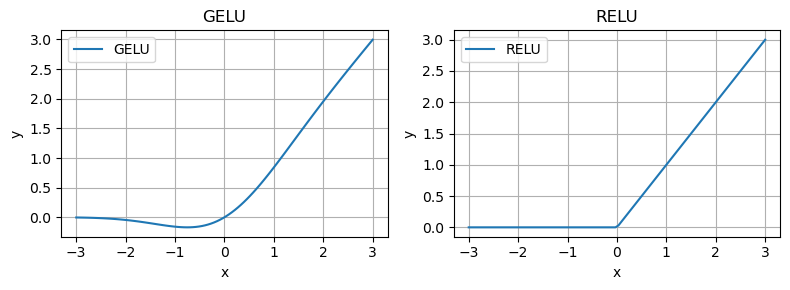

In [12]:
import matplotlib.pyplot as plt

# ___Plotting the GELU and ReLU activation function___
# ___This is a simple visualization to compare the GELU and ReLU activation functions___
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100) # Generate 100 points between -3 and 3
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y, label=label)
    plt.title(label)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [13]:
class FeedForward(nn.Module):
    # ___Feed-Forward Network (FFN) in Transformers___
    def __init__(self, cfg):
        super().__init__()
        # ___Initialize the feed-forward network with the given configuration___
        # ___cfg should contain keys like 'emb_dim', 'drop_rate', etc.___
        self.layer = nn.Sequential(
            nn.Linear(cfg.emb_dim, cfg.emb_dim * 4), # First linear layer with expansion
            nn.GELU(),
            nn.Linear(cfg.emb_dim * 4, cfg.emb_dim)  # Second linear layer with reduction
        )

    def forward(self, x):
        # ___Forward pass through the feed-forward network___
        # ___x is expected to be a tensor of shape (batch_size, seq_len, emb_dim)___
        # ___This is a placeholder for the actual forward pass implementation___
        return self.layer(x)




In [14]:
ffn = FeedForward(cfg)
x = torch.rand(2, 3, 768)

out = ffn(x)
print(out)


tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1051,  ...,  0.1438,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0702,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)


### 🔁 Shortcut (Residual) Connections in GPT-like Models

**What are they?**  
In Transformer-based architectures like GPT, shortcut connections (also known as residual connections) are used to directly pass the input of a layer to its output, bypassing the transformation. The typical form looks like:

```python
output = LayerNorm(x + F(x))

Here:
 • x is the input to the layer
 • F(x) is the layer’s transformation (e.g., attention or feed-forward output)
 • x + F(x) adds the raw input back to the transformed output
 • LayerNorm normalizes the combined result

⸻

Why are they useful?
 • ✅ Stabilize training by preventing vanishing or exploding gradients
 • ✅ Preserve useful information from earlier layers
 • ✅ Let the model decide how much to rely on the new transformation (F(x)) vs the original input (x)
 • ✅ Enable deeper networks without loss of gradient flow

⸻

How does the model decide what to keep?

It doesn’t “decide” explicitly. Through backpropagation:
 • If F(x) is unhelpful, gradients reduce its influence
 • If F(x) is useful, it gets more weight over training time
 • x always acts as a safety net

⸻

Summary:
Residual connections are a smart architectural trick that help the model learn deeper and faster, while avoiding instability. They allow the network to adaptively balance between learning new transformations and retaining original input information.

In [15]:
class ExampleDeepNeuralNetwork(nn.Module):
    # ___Example of a deep neural network with multiple layers and optional shortcuts___
    # ___This is a simple example to demonstrate the structure of a deep neural network in PyTorch___
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        # ___Initialize the deep neural network with the given layer sizes and shortcut option___
        # ___layer_size is a list of layer sizes, and use_shortcut is a boolean indicating whether to use shortcuts___
        # ___This is a placeholder for the actual deep neural network implementation___
        # ___use_shortcut is a boolean indicating whether to use shortcuts in the network___
        self.use_shortcut = use_shortcut
        
        # ___nn.ModuleList is used to create a list of layers that can be iterated over in the forward pass___
        # ___This allows for a flexible and modular design, where different layers can be easily added or modified__
        # ___In a real implementation, you would replace DummyLayer with actual layer classes that implement the desired functionality___#
        # ___ The difference between nn.ModuleList and nn.Sequential is that ModuleList allows for more flexibility in defining the forward pass,|>
        # |> while Sequential is a simple container for layers that are applied in order.___
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                        GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                        GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                        GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                        GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                        GELU())
            ])


    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x) 
            if self.use_shortcut == True and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        
        return x


In [16]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)

model_without_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=False
)

In [17]:
def print_gradients(model, x):
 output = model(x)
 target = torch.tensor([[0.]])
 
 loss = nn.MSELoss()
 loss = loss(output, target) 
 
 loss.backward()
 
 for name, param in model.named_parameters():
   if 'weight' in name:
    print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

### 🔍 Understanding `model.named_parameters()` in PyTorch

The function model.named_parameters() is a built-in PyTorch method that returns an iterator over all learnable parameters in the model, along with their names.

#### 🧠 What does this loop do?

```python
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

✅ Explanation:
 • name: The string name of the parameter (e.g., "layers.0.0.weight").
 • param: The actual tensor (wrapped in nn.Parameter) that stores the weights or biases.
 • param.grad: The gradient of the parameter, computed after calling loss.backward().

💡 The condition if 'weight' in name: filters out only the weights (excluding biases), and the mean of absolute gradients is printed for each.

⸻

🎯 Why is this useful?

This is a diagnostic tool to check whether gradients are flowing properly during backpropagation. If the gradients are very small or zero, it may indicate problems like vanishing gradients.

⸻

🔁 Summary Table

Part Description
model.named_parameters() Iterator of (name, parameter) pairs for all learnable parameters
param.grad Gradient tensor after backward pass
.abs().mean().item() Mean absolute gradient as a single float value (for readability)


⸻

📚 Use this to verify gradient flow or compare models (e.g., with vs. without shortcut connections).

In [18]:
print_gradients(model=model_without_shortcut, x=sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.00071520428173244
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


In [19]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


In [ ]:
class MultiHeadAttention(nn.Module):
     def __init__(self, d_in, d_out,
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

       #___Ensures d_out is evenly divisible by num_heads for equal head dimensions___
        assert (d_out % num_heads == 0), \
              "d_out must be divisible by num_heads"
        
        #___Initializes input and output dimensions, number of heads, and dropout rate___
        #___d_in: input dimension, d_out: output dimension, num_heads: number of attention heads___
        #___This is important for multi-head attention to work correctly___
        #___Ensures d_out is evenly divisible by num_heads for equal head dimensions___
        self.d_out = d_out
        self.num_heads = num_heads

        #___Reduces the projection dim to match the desired output dim___
        self.head_dim = d_out // num_heads
      
          #___Uses a Linear layer to project inputs to queries, keys, and values___
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        #___Uses a Linear layer to combine head outputs___
        #___Projects the concatenated context vectors to the output dimension___
        #___This is the final output of the attention mechanism___
        #___Ensures the output dimension matches the input dimension___
        #___This is important for residual connections in transformer architectures___
        self.out_proj = nn.Linear(d_out, d_out)

        #___Initializes dropout layer for regularization during training___
        #___Helps prevent overfitting by randomly setting some attention weights to zero___
        #___Dropout is applied to attention weights to improve generalization___
        #___This is a common practice in transformer architectures___
        self.dropout = nn.Dropout(dropout)
        
        #___Registers a buffer for the causal mask___
        #___This mask is used to prevent attending to future tokens in the sequence___
        #___This is important for autoregressive models like GPT___
        #___The mask is applied to attention scores to ensure causality___
        #___This is important for training models that generate text in a left-to-right manner___
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), 
                       diagonal=1)
        )
        

     def forward(self, x):
        #___Linear projections for queries, keys, and values___
        #___Extract batch size, number of tokens, and input dimension___
        #___b: batch size, num_tokens: number of tokens, d_in: input
        #___embedding dimension___
        #___This is important for multi-head attention to work correctly___
        b, num_tokens, d_in = x.shape     # x: (batch, seq_len, d_in)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        #__Reshape the keys to match number of heads and head dimension__
        # b: batch size
        # num_tokens: number of tokens
        # self.num_heads: number of attention heads
        # self.head_dim: dimension of each head
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
            
            #___Compute attention scores___
            #___Transpose keys, queries, and values for multi-head attention___
        #___This is important for multi-head attention to work correctly___
        keys = keys.transpose(1, 2)  # (b, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3)  # (b, num_heads, num_tokens, num_tokens)
        
        #___Apply causal mask to attention scores___
        # Ensure the mask is applied only to the relevant tokens
        num_tokens = attn_scores.shape[-1]
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        #___Normalize attention scores___
        attn_weights = torch.softmax(
            attn_scores / self.head_dim**0.5, dim=-1
        )

        #___Apply dropout to attention weights___
        attn_weights = self.dropout(attn_weights)

        #___Weighted sum of values___
        context_vecs = (attn_weights @ values).transpose(1, 2)  # (b, num_heads, num_tokens, head_dim)

        #___Reshape context vectors to combine heads___
        # Ensure the context vectors are contiguous in memory for efficient reshaping
        #contiguous() ensures that the tensor is stored in a contiguous block of memory
        #___This is important for efficient memory access and computation___
        #view() reshapes the tensor to the desired shape without changing its data
        context_vecs = context_vecs.contiguous().view(b, num_tokens, self.d_out)

        # (b, num_tokens, d_out)
        #___Project the context vectors to the output dimension___
        #out_proj makes sure the output dimension matches the input dimension and
        # ___This is important for residual connections in transformer architectures___
        # It makes it learnable to combine the output of the attention mechanism with the input
        context_vecs = self.out_proj(context_vecs)  # (b, num_tokens, d_out)
        
        return context_vecs

### 🧠 Conceptual Overview: TransformerBlock

The TransformerBlock is a fundamental building block of the Transformer architecture. It processes input token embeddings in two main stages to both integrate contextual relationships and perform deep nonlinear transformations. Here's a breakdown:

---

### 🔹 Stage 1: Multi-Head Self-Attention

1. Layer Normalization is applied first to stabilize training.
2. The input is passed through a Multi-Head Self-Attention module, allowing each token to attend to all others and learn dependencies.
3. A Dropout layer is used for regularization.
4. A Residual Connection is applied by adding the original input (`shortcut`) back to the attention output. This helps preserve the original features and improves gradient flow.

---

### 🔹 Stage 2: Feed Forward Network (FFN)

1. Another Layer Normalization is applied.
2. The data goes through a position-wise Feed Forward Neural Network, transforming each token independently with learned weights.
3. Dropout is again used for regularization.
4. A second Residual Connection adds the original input of this stage back to the FFN output.

---

### 🧩 Why this block matters

- Self-Attention enables the model to capture relationships between tokens — for example, understanding that "not" changes the sentiment of "good".
- Feed Forward layers apply complex transformations individually to each token, enhancing their representation.
- LayerNorm + Residuals make training faster, more stable, and deeper networks possible.

This block is like a LEGO brick — stacking many of these builds the full transformer. For example, GPT uses multiple such blocks to process text deeply and effectively. 🚀

In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.att = MultiHeadAttention(
            d_in=cfg.emb_dim,
            d_out=cfg.emb_dim,
            context_length=cfg.context_length,
            dropout=cfg.drop_rate,
            num_heads= cfg.n_heads,
            qkv_bias=cfg.qkv_bias,
        )

        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg.emb_dim)
        self.norm2 = LayerNorm(cfg.emb_dim)
        self.drop_shortcut = nn.Dropout(cfg.drop_rate)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 
        
        return x



In [22]:
torch.manual_seed(123)

# ___x is a random tensor with shape (batch_size, num_tokens, emb_dim)___
# ___This is a placeholder for the actual input tensor that the transformer block will process___
x = torch.rand(2, 4, 768)
block = TransformerBlock(cfg)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


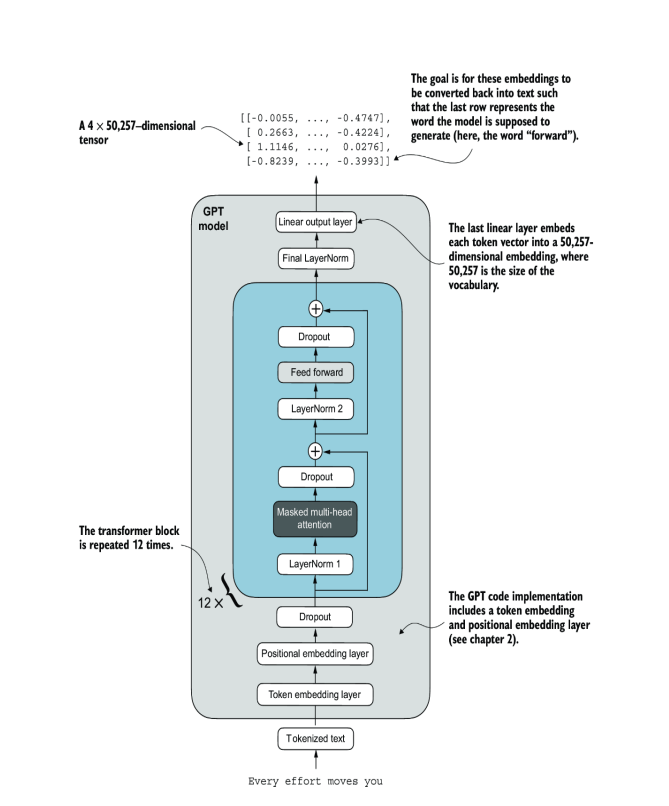

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.emb_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(cfg.context_length, cfg.emb_dim, padding_idx=0)
        self.drop_emb = nn.Dropout(cfg.drop_rate)

        self.trf_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg.n_layers)]
        )

        self.final_norm = LayerNorm(cfg.emb_dim)
        self.out_head = nn.Linear(cfg.emb_dim, cfg.vocab_size, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
            
        tok_embds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
            
        return logits



In [24]:
torch.manual_seed(123)
model = GPTModel(cfg=cfg)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.0916,  0.2058, -0.1608,  ..., -0.2172, -0.6503,  0.7887],
         [ 0.1792, -0.6052, -0.4672,  ..., -0.4354,  0.1537, -0.4869],
         [ 0.7416, -0.0322, -0.1145,  ...,  0.2878, -0.7329,  0.0868],
         [-0.4503,  0.3529, -0.0447,  ...,  1.2172,  0.4910, -0.5095]],

        [[-0.0880,  0.3545, -0.1494,  ...,  0.1486,  0.2259,  0.2632],
         [ 0.1553, -0.1107, -0.3038,  ...,  1.4718, -0.2542,  0.0806],
         [ 0.5024,  0.4906, -0.3690,  ...,  0.9405,  0.2201, -0.1660],
         [-0.0518, -0.0428,  0.3161,  ...,  1.2671, -0.5099,  0.0905]]],
       grad_fn=<UnsafeViewBackward0>)


Transformer blocks:

## 🧠 GPT Forward Pass Overview (with Batching)

In this section, we summarize the core steps of how a batch of tokenized sequences flows through our GPT-like model.

---

### 🔢 1. Input Shape (Batching)
Our input tensor `x` has the shape:

(batch_size, seq_length)

- Overview (wit number of sequences in the batch (e.g. 2 means 2 separate sentences).
- this section, number of tokens in each input sequence.

Example:  
Ifth Batching)

In thi it means we are feeding 2 sequences, each with 4 tokens.

---

### 🔤 2. Token and Positional Embeddings
We convert token IDs into dense vector representations:

```python
tok_emb = self.token_embedding_table(x)      # shape: (batch_size, seq_length, n_embd)
pos_emb = self.position_embedding_table[:, :seq_length, :]  # shape: (1, seq_length, n_embd)

Then combine them:

x = tok_emb + pos_emb

Note: We broadcast pos_emb over the batch dimension.

⸻

🧱 3. Transformer Blocks

The input embedding x is passed through a stack of Transformer blocks:

x = self.blocks(x)

 • Each block performs self-attention, normalization, and feed-forward transformation.
 • This stacking allows the model to learn complex hierarchical representations.

⸻

✅ 4. Layer Normalization

After all transformer blocks, we apply layer normalization:

x = self.ln_f(x)


⸻

🎯 5. Linear Head for Output Prediction

The final tensor is mapped to vocabulary space using a linear layer:

logits = self.lm_head(x)

 • logits.shape = (batch_size, seq_length, vocab_size)
 • Each position in each sequence outputs a probability distribution over vocabulary tokens.

⸻

🔁 Summary

The GPT forward pass processes batched token sequences by:
 1. Embedding tokens + positions
 2. Passing through Transformer layers
 3. Normalizing and projecting to vocabulary
This entire flow supports parallel processing of multiple sequences (batching) efficiently.

In [25]:
# ___p.numel() returns the total number of elements in the parameter tensor___
# ___sum(p.numel() for p in model.parameters()) calculates the total number of parameters
# ___ model.parameters() returns an iterator over all the parameters in the model___
# ___This is useful for understanding the model's complexity and memory requirements___
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [26]:
print("Token embedding layer:", model.tok_emb.weight.shape)
print("Output Layer shape:", model.out_head.weight.shape)

Token embedding layer: torch.Size([50257, 768])
Output Layer shape: torch.Size([50257, 768])


In [27]:
total_params_gpt2 = (
 total_params - sum(p.numel()
 for p in model.out_head.parameters())
)


print(f"Number of trainable parameters "
 f"considering weight tying: {total_params_gpt2:,}"
)


Number of trainable parameters considering weight tying: 124,412,160


### let’s compute the memory requirements of the 163
### million parameters in our GPTModel object:


In [28]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [29]:
model_example = TransformerBlock(cfg=cfg)

for name, param in model_example.named_parameters():
    print(f"Name:{name} | shape:{param.shape}")


Name:att.W_query.weight | shape:torch.Size([768, 768])
Name:att.W_key.weight | shape:torch.Size([768, 768])
Name:att.W_value.weight | shape:torch.Size([768, 768])
Name:att.out_proj.weight | shape:torch.Size([768, 768])
Name:att.out_proj.bias | shape:torch.Size([768])
Name:ff.layer.0.weight | shape:torch.Size([3072, 768])
Name:ff.layer.0.bias | shape:torch.Size([3072])
Name:ff.layer.2.weight | shape:torch.Size([768, 3072])
Name:ff.layer.2.bias | shape:torch.Size([768])
Name:norm1.scale | shape:torch.Size([768])
Name:norm1.shift | shape:torch.Size([768])
Name:norm2.scale | shape:torch.Size([768])
Name:norm2.shift | shape:torch.Size([768])


### Generating text :

In [ ]:
# ___Generate text using the model with a simple greedy decoding strategy___
# ___This function generates text by repeatedly predicting the next token based on the current context___
# ___idx is a tensor of token indices with shape (batch_size, seq_len)___
# ___max_new_tokens is the number of new tokens to generate___
# ___context_size is the size of the context window used for generating new tokens___
def generate_text_simple(model, idx,
                         max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # ___Extract the last context_size tokens from idx for generating the next token___
        # ___idx_cond is a tensor of shape (batch_size, context_size)___
        # ___ idx[:, -context_size:] means we take the last context_size tokens from idx___
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            # ___Pass the context tokens through the model to get logits for the next token___
            # ___logits is a tensor of shape (batch_size, context_size, vocab_size
            logits = model(idx_cond)

        # ___Extract the logits for the last token in the sequence___
        # ___logits[:, -1, :] gives us the logits for the last token in the sequence___
        # ___This is the output of the model for the next token prediction___
        # print(logits.dtype)
        logits = logits[:, -1, :] 
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [31]:
start_context = "Hello, I am"

# ___This is the initial context for generating text___
# ___It is a string that will be tokenized and used as the starting point for text generation___
# ___The model will generate new tokens based on this context___
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

# ___Convert the encoded context into a PyTorch tensor and add a batch dimension___
# ___This is necessary to feed the token indices into the model for processing___
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimensio
print("encoded_tensor.shape:", encoded_tensor.shape) # (1, seq_len)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [32]:
model.eval() # Set the model to evaluation mode
# ___This is important for models that have different behavior during training and evaluation, such as dropout layers___
# ___In evaluation mode, dropout layers are disabled, and the model behaves deterministically___

out = generate_text_simple(
    model, idx=encoded_tensor,
    max_new_tokens=6,
    context_size=cfg.context_length
)

print("output:", out)
print("output Length", len(out[0]))

output: tensor([[15496,    11,   314,   716, 27018,  7283, 46275, 11472, 11387, 30975]])
output Length 10


In [33]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Feature IT snowball shocked threshold allerg
